# 프로젝트 : 작사가 인공지능 만들기

**시작하기에 앞서, 이번 프로젝트는 봐도 이해가 가지 않는 것들이 많아 생각만큼 정리가 잘 되지 않습니다.  
대신 LMS 내용을 보고 본래의 배운다는 느낌에 중점을 둬서 차근차근 알아보는 과정을 거치도록 하겠습니다.**

## 1. 데이터 불러오기
- **데이터 다운로드**
- **데이터 읽어오기**

## 2. 데이터 전처리
- **데이터 정제하기**
- **데이터 벡터화**

## 3. 인공지능 만들기
- **모델 설계하기**
- **모델 학습하기**
- **학습 결과 확인하기**


- - -
### 데이터 불러오기
- **데이터 다운로드**

In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
import glob
import re

txt_file_path = '/content/drive/MyDrive/Colab Notebooks/exp/lyricist/data/lyrics/*' #os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. txt_file_path 에 "/root/aiffel/lyricist/data/lyrics/*" 저장

txt_list = glob.glob(txt_file_path) #txt_file_path 경로에 있는 모든 파일명을 리스트 형식으로 txt_list 에 할당

처음 등장한 `glob` 모듈의 `glob` 함수는 경로에 있는 모든 파일명을 리스트로 만들어줍니다.

단, 조건에 정규식을 사용할 수 없으며 엑셀 등에서도 사용할 수 있는 `*`와 `?`같은 와일드카드만을 지원합니다.  
_ex)_ `glob.glob('/aiffel/*')`

In [91]:
txt_list[:5]

['/content/drive/MyDrive/Colab Notebooks/exp/lyricist/data/lyrics/missy-elliott.txt',
 '/content/drive/MyDrive/Colab Notebooks/exp/lyricist/data/lyrics/lady-gaga.txt',
 '/content/drive/MyDrive/Colab Notebooks/exp/lyricist/data/lyrics/bob-marley.txt',
 '/content/drive/MyDrive/Colab Notebooks/exp/lyricist/data/lyrics/nicki-minaj.txt',
 '/content/drive/MyDrive/Colab Notebooks/exp/lyricist/data/lyrics/leonard-cohen.txt']

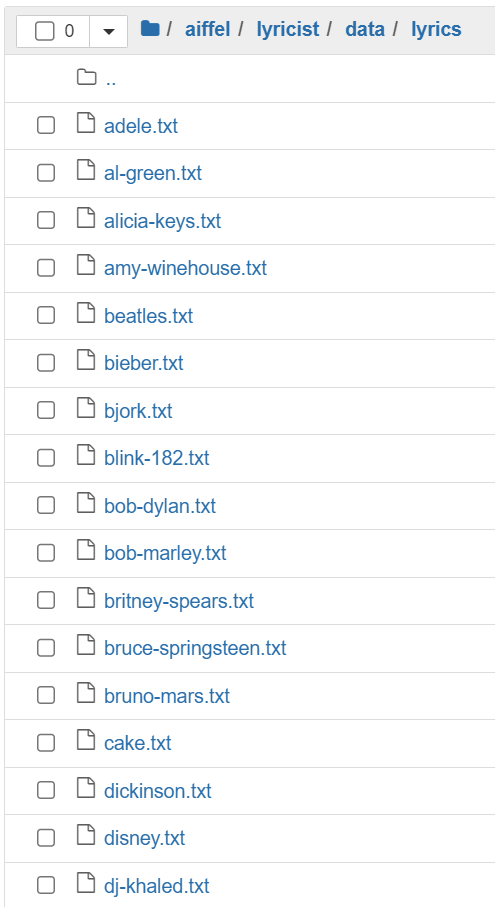

리스트에 담기는 순서는 파일명이나 파일 크기와 관계가 없는 듯 합니다.

- - -
### 데이터 불러오기
- **데이터 읽어오기**

In [92]:
raw_corpus = [] 

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() #read() : 파일 전체의 내용을 하나의 문자열로 읽어온다. , splitlines()  : 여러라인으로 구분되어 있는 문자열을 한라인씩 분리하여 리스트로 반환
        raw_corpus.extend(raw) # extend() : 리스트함수로 추가적인 내용을 연장 한다.

모든 파일명에 대해 반복으로 실행을 하면서 파일들에 있는 모든 내용을 줄 단위로 읽어 리스트 `raw_corpus`에 담습니다.

In [93]:
print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ["I'mma start it from the bottom", "I'll show you how to flip a dollar", 'I got food in my dining room']


총 187088개의 문장이 리스트에 담겼고, 앞에서 3개의 요소를 가져와봤습니다.

In [94]:
raw[:3]

['Look, I was gonna go easy on you and not to hurt your feelings',
 "But I'm only going to get this one chance",
 "Something's wrong, I can feel it (Six minutes, Slim Shady, you're on)"]

`raw`는 **for**문이 반복될 때마다 갱신되면서 반복문의 마지막으로 읽은 파일에 대한 내용이기 때문에 `raw_corpus`와는 다릅니다.

- - -
### 데이터 전처리
- **데이터 정제하기**

In [95]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,'¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


정규표현식을 이용해 문장의 개요에는 맞지 않는 불필요한 문자들을 제거해주는 함수입니다.

In [127]:
sample_text = ' asdASD(asd?)    @@ ' # 1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
sample_text = sample_text.lower().strip()
sample_text

'asdasd(asd?)    @@'

**1. 대문자들이 소문자로 바뀌고 양쪽의 공백이 지워졌습니다.**  
`' asdASD(asd?)    @@ '` → `'asdasd(asd?)    @@'`

In [128]:
sample_text = re.sub(r"([?.!,¿])", r" \1 ", sample_text) # 2. 특수문자 양쪽에 공백을 넣고
sample_text

'asdasd(asd ? )    @@'

**2. `([?.!,¿])` 안에 해당했던 `?`의 양쪽에 공백이 추가됐습니다.**  
`'asdasd(asd?)    @@'` → `'asdasd(asd ? )    @@'`

In [129]:
sample_text = re.sub(r'[" "]+', " ", sample_text) # 3. 여러개의 공백은 하나의 공백으로 바꿉니다
sample_text

'asdasd(asd ? ) @@'

**3. `@@` 전에 있던 여러 개의 공백이 하나의 공백으로 바뀌었습니다.**  
`'asdasd(asd ? )    @@'` → `'asdasd(asd ? ) @@'`

In [130]:
sample_text = re.sub(r"[^a-zA-Z?.!,'¿]+", " ", sample_text) # 4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
sample_text

'asdasd asd ? '

**4. `[^a-zA-Z?.!,'¿]` 안에 포함되지 않던 `(`와 `)`이 공백으로 바뀌었습니다.**  
`'asdasd(asd ? ) @@'` → `'asdasd asd ? '`

In [131]:
sample_text = sample_text.strip() # 5. 다시 양쪽 공백을 지웁니다
sample_text

'asdasd asd ?'

**5. 양쪽 끝끝에 공백이 다시 생겼다면 제거합니다.**  
`'asdasd asd ? '` → `'asdasd asd ?'`

In [132]:
sample_text = '<start> ' + sample_text + ' <end>' # 6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
sample_text

'<start> asdasd asd ? <end>'

**6. 문장의 처음과 끝에 `<start>`와 `<end>`를 추가합니다.**  
`'asdasd asd ?'` → `'<start> asdasd asd ? <end>'`

In [102]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장
for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    
    # 앞서 구현한 preprocess_sentence() 함수를 이용하여 문장을 정제를 하고 담아주세요
    tokenize = preprocess_sentence(sentence)
    if len(tokenize.split()) <= 15:
        corpus.append(tokenize)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

["<start> i'mma start it from the bottom <end>",
 "<start> i'll show you how to flip a dollar <end>",
 '<start> i got food in my dining room <end>',
 "<start> i'm better , i'm better , i'm better <end>",
 "<start> it's another day , another chance <end>",
 '<start> i wake up , i wanna dance <end>',
 '<start> so as long as i got my friends <end>',
 '<start> pull up on him in my vehicle <end>',
 "<start> he say i'm pretty , i'm pretty <end>",
 '<start> you must be from brazil , it must be from m xico <end>']

`raw_corpus`에 들어있던 문장을 전부 위에서 만들었던 함수를 거쳐 정제합니다.

정제를 하면서 혹시 길이가 0인 문장은 제외하고 리스트에 담습니다.

저는 `if len(tokenize.split()) <= 15:` 조건문을 추가해서 토큰화를 했을 때 토큰의 개수가 15개가 넘어가는 문장은 제외해줬습니다.

- - -
### 데이터 전처리
- **데이터 벡터화**

In [103]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
import tensorflow as tf

# 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
# 우리는 이미 문장을 정제했으니 filters가 필요없어요
# 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=7000, filters=' ', oov_token="<unk>")

텐서플로우 모듈을 불러와 `tensorflow.keras.preprocessing.text.Tokeizer` 함수를 실행합니다.

함수의 인자로 `num_words, filters, oov_token`을 넣습니다.

`num_words=7000` : 빈도가 많은 순서로 7000개의 단어를 보존한다.  
`filters=' '` : 걸러낼 문자 리스트를 적어준다. 디폴트는 ```!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n``` 이다.  `' '`를 넣었으니 따로 걸러내는 문자는 없다.  
`oov_token="<unk>"` : 7000개의 단어에 포함되지 못한 단어는 `<unk>`로 일괄 통일한다. 7000개의 단어 끝에 추가해서 총 7001개의 단어가 된다.

In [104]:
tokenizer.fit_on_texts(corpus)

type(tokenizer)

keras_preprocessing.text.Tokenizer

모델의 타입을 확인해보면 함수 그 자체로 반환됩니다.

In [105]:
# 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
# tokenizer.texts_to_sequences(texts): 텍스트 안의 단어들을 숫자의 시퀀스 형태로 변환하는 메서드

tensor = tokenizer.texts_to_sequences(corpus)
tensor[:15]

[[2, 553, 348, 13, 67, 5, 943, 3],
 [2, 102, 185, 7, 74, 10, 1148, 9, 1106, 3],
 [2, 6, 34, 1348, 14, 12, 3401, 373, 3],
 [2, 21, 148, 4, 21, 148, 4, 21, 148, 3],
 [2, 54, 199, 119, 4, 199, 542, 3],
 [2, 6, 537, 27, 4, 6, 85, 226, 3],
 [2, 29, 76, 169, 76, 6, 34, 12, 276, 3],
 [2, 452, 27, 16, 142, 14, 12, 5585, 3],
 [2, 58, 65, 21, 388, 4, 21, 388, 3],
 [2, 7, 285, 25, 67, 1, 4, 13, 285, 25, 67, 334, 1, 3],
 [2, 421, 27, 16, 142, 14, 12, 1, 3],
 [2, 832, 52, 20, 1, 4, 45, 2665, 3],
 [2, 717, 34, 2021, 14, 5586, 3],
 [2, 954, 6, 34, 762, 15, 58, 2580, 26, 3],
 [2, 82, 6, 25, 98, 184, 10, 944, 3]]

만들었던 `tokenizer` `texts_to_sequences` 모델의 함수를 실행하니 `corpus`의 문장이 숫자의 시퀀스 형태로 변환되었습니다.

앞서 넣었던 인자들로 `[2, 553, 348, 13, 67, 5, 943, 3]`는 *2번 째로 많은 빈도의 단어, 553번 째로 많은 빈도의 단어, 348번 째로 많은 빈도의 단어, 13번 째...*

식으로 인코딩되었습니다.

In [106]:
# 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
# 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
# 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다

tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
tensor

array([[   2,  553,  348, ...,    0,    0,    0],
       [   2,  102,  185, ...,    0,    0,    0],
       [   2,    6,   34, ...,    0,    0,    0],
       ...,
       [   2,  269,  188, ...,    3,    0,    0],
       [   2,  130,   21, ...,   10, 1108,    3],
       [   2,    7,   32, ...,    0,    0,    0]], dtype=int32)

가장 길이가 긴 문장을 기준으로 짧은 문장은 나머지를 `0`의 값을 채워 사이즈를 맞춰줍니다.

In [107]:
def tokenize(corpus, num_words):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=num_words,
        filters=' ',
        oov_token="<unk>"
    )
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor)
    return tensor, tokenizer

위 벡터화 과정들을 데이터와 텐서**(tensor)**화 할 단어의 수**(`num_words`)**를 인자로 받는 하나의 함수로 묶었습니다.

In [133]:
words = []

for sentence in corpus:
    word = sentence.split()
    
    for i in word:
        words.append(i)

len(set(words))

27554

`corpus`에는 총 *27554*종류의 단어가 등장합니다.

이것을 참고해서 텐서화할 단어의 수를 정하면 되겠습니다.

In [109]:
tensor, tokenizer = tokenize(corpus, num_words=12000)

[[   2  553  348 ...    0    0    0]
 [   2  102  185 ...    0    0    0]
 [   2    6   34 ...    0    0    0]
 ...
 [   2  269  188 ...    3    0    0]
 [   2  130   21 ...   10 1108    3]
 [   2    7   32 ...    0    0    0]]


저는 *12000* 종류의 단어를 사용해 `corpus`를 벡터화했습니다.

In [110]:
# tokenizer.index_word: 현재 계산된 단어의 인덱스와 인덱스에 해당하는 단어를 dictionary 형대로 반환 (Ex. {index: '~~', index: '~~', ...})
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : the
6 : i
7 : you
8 : and
9 : a
10 : to


`tokenizer.index_word`를 하면 문장에 들어갔던 단어와 인덱스들을 확인할 수 있습니다.

앞에서 10개의 단어를 확인해본 결과 `<unk>` 처리된 단어가 제일 많았고

`<start>`와 `<end>`를 제외하고 가장 많이 나온 단어는 `,`, `the`, `i`, `you`, `and`정도가 되겠습니다.

- - -
### 인공지능 만들기
- **모델 설계하기**

In [111]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2 553 348  13  67   5 943   3   0   0   0   0   0   0]
[553 348  13  67   5 943   3   0   0   0   0   0   0   0]


`src_input`는 마지막 토큰을 제거한 소스 문장이 되겠고

`tgt_input`는 첫 번째 `<start>` 토큰을 제거한 소스 문장이 되겠습니다.

요점은 타겟 데이터의 `<start>` 제거인데 학습용 데이터도 크기를 맞춰야 해서 `<end>`가 됐든 `<pad>`가 됐든 마지막 토큰을 제거해 크기를 맞춰주려는 것 같습니다.

In [112]:
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, shuffle=True, random_state=1337)

print(enc_train.shape)
print(dec_train.shape)

(127099, 14)
(127099, 14)


`sklearn` 모듈의 `train_test_split` 함수를 이용해 `train`과 `validation` 셋으로 분리를 해줬습니다.

In [113]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

print(f'BUFFER_SIZE : {BUFFER_SIZE}', f'steps_per_epoch : {steps_per_epoch}', sep='\n')

BUFFER_SIZE : 158874
steps_per_epoch : 620


`BUFFER_SIZE`는 데이터의 크기가 되겠습니다. 원래 약 18만 개였던 데이터에서 15만 개로 줄어든 이유는 정제를 거쳤기 때문입니다.

`steps_per_epoch`는 `BATCH_SIZE`만큼 나눠질 데이터의 개수입니다. *(158874 / 256 = 620.60)*

In [114]:
# tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함하여 12001개
# tokenizer.num_words: 주어진 데이터의 문장들에서 빈도수가 높은 n개의 단어만 선택
# tokenize() 함수에서 num_words를 12000개로 선언했기 때문에, tokenizer.num_words의 값은 12000
VOCAB_SIZE = tokenizer.num_words + 1
VOCAB_SIZE

12001

`VOCAB_SIZE` 변수에 *12000*에서 `0:<pad>`가 포함된 실질적인 단어의 개수 *12001*을 선언합니다.

In [115]:
# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset

dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(14,), dtype=tf.int32, name=None), TensorSpec(shape=(14,), dtype=tf.int32, name=None))>

데이터를 `tensorflow`용 데이터셋으로 만들어줍니다.

In [116]:
dataset = dataset.shuffle(BUFFER_SIZE)
dataset

<ShuffleDataset element_spec=(TensorSpec(shape=(14,), dtype=tf.int32, name=None), TensorSpec(shape=(14,), dtype=tf.int32, name=None))>

`shuffle` 메서드로 데이터셋을 섞어줍니다.

In [117]:
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(256, 14), dtype=tf.int32, name=None), TensorSpec(shape=(256, 14), dtype=tf.int32, name=None))>

`batch` 메서드로 데이터셋을 상수 `BATCH_SIZE` 만큼 결합합니다.

In [118]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        # Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있다.
        # Embedding 레이어는 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔준다.
        # 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현으로 사용된다. 
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.dropout = tf.keras.layers.Dropout(rate=0.3)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.dropout(out)
        out = self.linear(out)
        
        return out
    
# embedding size 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만
# 그만큼 충분한 데이터가 없으면 안좋은 결과 값을 가져옵니다!

embedding_size = 256 # 워드 벡터의 차원수를 말하며 단어가 추상적으로 표현되는 크기입니다.
hidden_size = 2048 # 모델에 얼마나 많은 일꾼을 둘 것인가? 정도로 이해하면 좋다.
model = TextGenerator(VOCAB_SIZE, embedding_size , hidden_size)

`tensorflow.keras.Model`의 학습을 관리하기 위한 클래스입니다.

저는 여기서 과적합을 방지하기 위해 `tf.keras.layers.Dropout(rate=0.3)`을 추가해줬습니다.

나머지 내용을 이해하기엔 저에게 아직 이르다고 느껴집니다..

`embedding_size = 256`  
`hidden_size = 2048`을 넣고 모델을 준비했습니다.

In [119]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-6.73801769e-05,  2.21908223e-04,  1.75872061e-04, ...,
         -1.16338751e-05,  1.08819848e-04, -3.00049607e-04],
        [-1.10768946e-04,  4.82446339e-04,  3.12124350e-04, ...,
          1.09698478e-04,  2.78150343e-04, -4.81783820e-04],
        [-1.03561542e-05,  7.16305338e-04,  2.77574465e-04, ...,
          3.54934629e-04,  3.41508421e-04, -4.39671363e-04],
        ...,
        [ 7.36282382e-04, -3.10730567e-04, -8.55368329e-04, ...,
          2.04999512e-03, -9.80365090e-04,  5.00964175e-04],
        [ 7.76488974e-04, -7.89525744e-04, -9.15193756e-04, ...,
          2.07140925e-03, -1.20015303e-03,  5.63614827e-04],
        [ 7.62343756e-04, -1.21156615e-03, -9.28101421e-04, ...,
          2.04283558e-03, -1.40925264e-03,  6.19356812e-04]],

       [[-6.73801769e-05,  2.21908223e-04,  1.75872061e-04, ...,
         -1.16338751e-05,  1.08819848e-04, -3.00049607e-04],
        [-2.32680672e-04,  2.47974996e-04,  3

256개의 데이터로 나눴던 배치 데이터 중 1개의 배치 데이터를 불러옵니다.

`shape=(256, 14, 12001)`의 내용은 각각 배치 사이즈, 시퀀스 길이, 단어의 개수를 뜻합니다.

배치한 데이터 하나를 불러와서 모델에 넣어보니 값이 굉장히 낮은 소수로 변환된 것을 확인할 수 있습니다.

    (for문에서 탈출을 했는데도 for문에서 사용했던 변수가 불러와지는 원리가 대체 뭐죠?)

In [120]:
# 모델의 구조를 확인합니다.
model.summary()

Model: "text_generator_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     multiple                  3072256   
                                                                 
 lstm_18 (LSTM)              multiple                  18882560  
                                                                 
 lstm_19 (LSTM)              multiple                  33562624  
                                                                 
 dropout_9 (Dropout)         multiple                  0         
                                                                 
 dense_6 (Dense)             multiple                  24590049  
                                                                 
Total params: 80,107,489
Trainable params: 80,107,489
Non-trainable params: 0
_________________________________________________________________


배치 데이터 중 하나를 모델에 넣고 나니 8000만 개의 파라미터가 생성되었습니다.

In [121]:
# optimizer와 loss등은 차차 배웁니다
# 혹시 미리 알고 싶다면 아래 문서를 참고하세요
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
# 양이 상당히 많은 편이니 지금 보는 것은 추천하지 않습니다

# Adam 알고리즘을 구현하는 optimzier이며 어떤 optimzier를 써야할지 모른다면 Adam을 쓰는 것도 방법이다.
# 우리가 학습을 할 때 최대한 틀리지 않는 방향으로 학습을 해야한다.
# 여기서 얼마나 틀리는지(loss)를 알게하는 함수가 손실함수 이다.
# 이 손실함수의 최소값을 찾는 것을 학습의 목표로 하며 여기서 최소값을 찾아가는 과정을 optimization 이라하고
# 이를 수행하는 알고리즘을 optimizer(최적화)라고 한다.

optimizer = tf.keras.optimizers.Adam() # Adam은 현재 가장 많이 사용하는 옵티마이저이다. 자세한 내용은 차차 배운다.
loss = tf.keras.losses.SparseCategoricalCrossentropy( # 훈련 데이터의 라벨이 정수의 형태로 제공될 때 사용하는 손실함수이다.
    from_logits=True, # 기본값은 False이다. 모델에 의해 생성된 출력 값이 정규화되지 않았음을 손실 함수에 알려준다. 즉 softmax함수가 적용되지 않았다는걸 의미한다. 
    reduction='none'  # 기본값은 SUM이다. 각자 나오는 값의 반환 원할 때 None을 사용한다.
)
# 모델을 학습시키키 위한 학습과정을 설정하는 단계이다.
model.compile(loss=loss, optimizer=optimizer) # 손실함수와 훈련과정을 설정했다.

손실 함수까지 지정하고 `model.complie`을 하면서 설계를 마칩니다.

- - -
### 인공지능 만들기
- **모델 학습하기**

Epoch 1/10
497/497 [==============================] - 23s 40ms/step - loss: 3.3767 - val_loss: 3.0158
Epoch 2/10
497/497 [==============================] - 19s 38ms/step - loss: 2.8756 - val_loss: 2.7677
Epoch 3/10
497/497 [==============================] - 19s 38ms/step - loss: 2.6004 - val_loss: 2.5810
Epoch 4/10
497/497 [==============================] - 19s 38ms/step - loss: 2.3316 - val_loss: 2.4416
Epoch 5/10
497/497 [==============================] - 19s 38ms/step - loss: 2.0804 - val_loss: 2.3364
Epoch 6/10
497/497 [==============================] - 19s 38ms/step - loss: 1.8577 - val_loss: 2.2640
Epoch 7/10
497/497 [==============================] - 19s 38ms/step - loss: 1.6689 - val_loss: 2.2143
Epoch 8/10
497/497 [==============================] - 19s 38ms/step - loss: 1.5151 - val_loss: 2.1813
Epoch 9/10
497/497 [==============================] - 19s 38ms/step - loss: 1.3907 - val_loss: 2.1713
Epoch 10/10
497/497 [==============================] - 19s 38ms/step - loss: 1.290

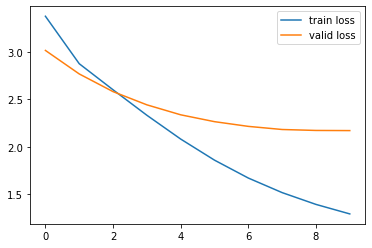

In [122]:
import matplotlib.pyplot as plt

history = model.fit(enc_train, dec_train, epochs=10, batch_size=256, validation_data=(enc_val, dec_val))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'valid loss'], loc='upper right')
plt.show()

10번의 `epochs` 안에 `val_loss`가 2.2 이하로 내려갔습니다.

In [123]:
#문장생성 함수 정의
#모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20): #시작 문자열을 init_sentence 로 받으며 디폴트값은 <start> 를 받는다
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence]) #텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다 (도달 하지 못하였으면 while 루프를 돌면서 다음 단어를 예측)
    while True: #루프를 돌면서 init_sentence에 단어를 하나씩 생성성
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4 
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated #최종적으로 모델이 생성한 문장을 반환

시작 문장을 입력받으면 마지막 단어 다음에 올 단어를 예측합니다.

예측하고 나면 무한 루프를 돌면서 이전에 예측했던 단어의 다음에 올 단어를 계속 예측하다가

`<end>`를 예측하거나 문장 최대 길이가 설정 값에 도달하면 문장 생성을 멈추고 완성된 문장을 반환하는 함수입니다.

- - -
### 인공지능 만들기
- **학습 결과 확인하기**

In [124]:
lyricist = model

generate_text(lyricist, tokenizer, init_sentence="<start> i love") # 시작문장으로 i love를 넣어 문장생성 함수 실행

'<start> i love you , i love you <end> '

학습한 모델로 문장 완성 함수에 시작문장으로 `i love`를 입력한 결과

`i love you , i love you`라는 문장을 출력했습니다. 쉽게 예상해볼 수 있는 문장입니다.

In [125]:
generate_text(lyricist, tokenizer, init_sentence="<start> i am")

"<start> i am the one for you i'm the one yeah i'm the one <end> "

`i am` 이라는 단어를 입력하니 `i am the one for you i'm the one yeah i'm the one` 이라는 문장을 출력해줬습니다.

번역하자면 *'내가 널 위한 사람인걸'* 이라는 뜻입니다.

DJ Khaled의 I'm the One 가사 일부군요.

In [126]:
generate_text(lyricist, tokenizer, init_sentence="<start> you are")

'<start> you are the lady in my life doo doo doo <end> '

이번엔 `you are`을 입력했더니 `you are the lady in my life doo doo doo` 라는 문장을 출력해줬습니다.

*'너는 내 여자 두두두(?)'* 라고 합니다. 이것도 노래 가사의 일부에서 크게 인용한 것 같습니다.

## 마무리하며

LMS를 읽고도 백지 상태였습니다.

아무리 읽어도 정리가 되지 않을 것 같아 프로젝트를 작성하면서 정리를 해보자 하며 다른 프로젝트랑은 조금 다른 느낌으로 시작을 했습니다.

최대한 코드를 하나하나 따로 실행해가며 동작 원리를 파악해보았는데

여전히 모델의 학습 원리나 손실 함수와 평가 지표를 구하는 방식에는 이해가 가지 않는 부분이 많습니다.  
<u>(for문에서 끝난 변수는 도대체 어떻게 불러와지는거죠??)</u>

여차저차 코드를 모두 유심히 살펴보고 거의 다 작성해갈 때 쯤 그래도 과정에 대해선 어느 정도 이해를 했는데요.

학습을 돌려보니 루브릭 평가 기준 중 하나인 10번의 학습 안에 `val_loss` 손실이 2.2 이하를 9 epoch에서 달성을 해놓고 10 epoch에서 다시 2.2 이상으로 올라가는 겁니다.

`hidden size`를 높여서 파라미터의 수를 늘리면 확실히 학습 결과는 좋아지는데 10 epoch부터 오버피팅이 발생하는겁니다.

사실 학습을 10번이 아닌 9번만 반복하면 해결될 문제이기는 했으나 어째선지 그러고 싶지는 않았죠.

결국 인터넷에서 오버피팅 방지 방법을 찾아 이해가 가지도 않은 모델 설정에 `Dropout`을 넣고 해결했습니다.

그래도 아직 커널을 실행할 때마다 2.2이하가 될 수도 있고, 안될 수도 있죠.

그 외에 오버피팅을 방지하는 방법도 여러가지를 발견하긴 했는데, 과적합 방지도 너무 과하면 학습량이 떨어져 10번의 epoch 안에 2.2 근처도 가지지가 않겠죠.

텐서플로우.. 열심히 공부해봐야 할 것 같습니다.

프로젝트를 작성하면서 가장 큰 소득은 코랩의 위대함을 깨달았다는 것입니다.

다들 '코랩이 좋다', '코랩이 빠르다' 라고 얘기할 때 저는 그래도 Aiffel Cloud도 쓸만하다 싶었고 오히려 데이터셋을 불러오기 편해서 많이 적응을 한 상태였습니다.

코랩으로 이사를 가기 전 Aiffel Cloud에서 주피터 노트북으로 실행할 땐 학습 10번에 40분이 소모됐었는데요.

실행 속도가 너무 오래 걸려서 코랩이 빠르다고들 하시니 혹시나 하는 마음에 코랩에서 실행 결과 학습 10번에 4분 밖에 걸리지 않았습니다.

다만 데이터셋을 같이 옮겨오는 과정이 처음에 좀 어렵고 번거롭기는 했습니다.

그래도 앞으로 학습 하는 데에 시간이 걸리는 경우가 종종 있을테니 코랩에서 작성하는 것도 연습해봐야 할 것 같습니다.